In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
ds = tfds.load('deep_weeds', split='train', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/17509 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/deep_weeds/3.0.0.incompleteWDNI8M/deep_weeds-train.tfrecord*...:   0%|    …

Dataset deep_weeds downloaded and prepared to /root/tensorflow_datasets/deep_weeds/3.0.0. Subsequent calls will reuse this data.


In [ ]:
import numpy as np
images_main = []
images_anomaly = []
labels_main= []
labels_anomaly = []
ds = ds.prefetch(tf.data.AUTOTUNE)
for example in ds:
  #print(np.array(example['label']))
  if np.array(example['label']) == 5:
    images_main.append(example["image"])
    labels_main.append(example["label"])
  if np.array(example['label']) == 1:
    images_anomaly.append(example["image"])
    labels_anomaly.append(example["label"])

In [ ]:
import matplotlib.pyplot as plt

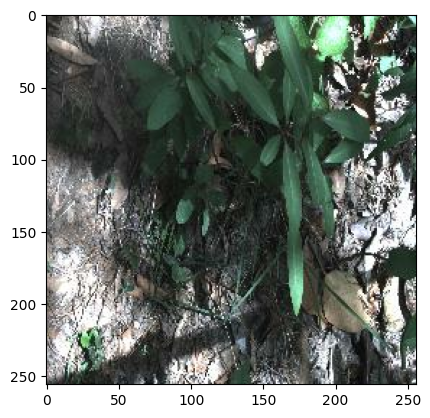

In [ ]:
plt.imshow(images_main[2])

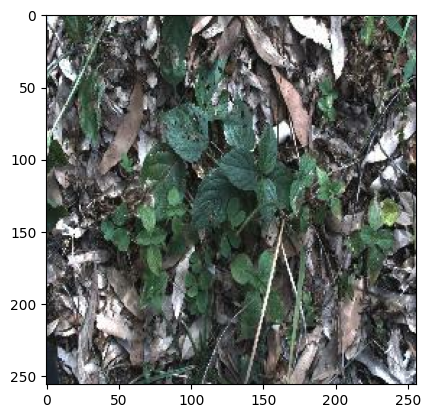

In [ ]:
plt.imshow(images_anomaly[5])

In [ ]:
parc = round(len(labels_anomaly) * 0.01)
images_anomaly = np.array(images_anomaly)[:parc]
# stacking the main images and anomaly images together
total_images = np.vstack([images_main, images_anomaly])

In [ ]:
total_images[0].shape

(256, 256, 3)

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2

In [ ]:
(train_x, test_x) = train_test_split(total_images, test_size=0.2, random_state=0)

In [ ]:
filters=(16, 32, 64)
latentDim=32


input_shape = total_images[0].shape
n_channels = input_shape[-1]
chanDim = -1
inputs = Input(shape=input_shape)
x = inputs

for f in filters:
  x = Conv2D(f, (3, 3), strides = 2, padding="same")(x)
  x = LeakyReLU(alpha=0.3)(x)
  x = BatchNormalization(axis=chanDim)(x)

volume = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latentDim)(x)

#encoder model
encoder = Model(inputs, latent, name="encoder")

#compressed representation
latent_layer_input = Input(shape=(latentDim,))
x = Dense(np.prod(volume[1:]))(latent_layer_input)

x = Reshape((volume[1], volume[2], volume[3]))(x)

#Recostructing the image with a decoder model
for f in filters[::-1]:
  x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
  x = LeakyReLU(alpha=0.3)(x)
  x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(n_channels, (3, 3), padding="same")(x)

outputs = Activation("sigmoid")(x)

decoder = Model(latent_layer_input, outputs, name="decoder")

autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")



In [ ]:
epochs = 50
lr_start = 0.001
batchSize = 32

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

In [ ]:
opt = tf.keras.optimizers.legacy.Adam(lr = lr_start, decay = lr_start / epochs)
autoencoder.compile(loss = "mse", optimizer = opt)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = autoencoder.fit(
 train_x, train_x,
 validation_data=(test_x, test_x),
 epochs=30,
 batch_size=batchSize)

Epoch 1/30
26/26 [==============================] - 17s 162ms/step - loss: 13095.2490 - val_loss: 12849.7578
Epoch 2/30
26/26 [==============================] - 2s 96ms/step - loss: 13062.2129 - val_loss: 12879.3506
Epoch 3/30
26/26 [==============================] - 3s 111ms/step - loss: 13048.5469 - val_loss: 12885.7607
Epoch 4/30
26/26 [==============================] - 2s 95ms/step - loss: 13043.0010 - val_loss: 12832.7031
Epoch 5/30
26/26 [==============================] - 2s 96ms/step - loss: 13039.7754 - val_loss: 12782.6787
Epoch 6/30
26/26 [==============================] - 2s 94ms/step - loss: 13040.6934 - val_loss: 12863.5957
Epoch 7/30
26/26 [==============================] - 2s 96ms/step - loss: 13036.9404 - val_loss: 12783.6934
Epoch 8/30
26/26 [==============================] - 3s 99ms/step - loss: 13034.3809 - val_loss: 12769.9189
Epoch 9/30
26/26 [==============================] - 3s 98ms/step - loss: 13032.8691 - val_loss: 12767.2324
Epoch 10/30
26/26 [===============

In [ ]:
decoded = autoencoder.predict(test_x)
errors = []
for (image, recon) in zip(total_images, decoded):
  mse = np.mean((image - recon) ** 2)
  errors.append(mse)

7/7 [==============================] - 1s 42ms/step


In [ ]:
thresh = np.quantile(errors, 0.95)
idxs = np.where(np.array(errors) >= thresh)[0]
idxs

array([ 10,  12,  38,  54,  87, 135, 147, 188, 201, 202, 203])

In [ ]:
for i in idxs:
  if total_images[i] in images_anomaly:
    print(True)

True
True
True
True
True
True
True
True
True
True
True


In [ ]:
len(images_anomaly)

11